# PeakWeather Demo

In [2]:
from peakweather import PeakWeatherDataset

import matplotlib.pyplot as plt

## Loading the data

To get the dataset, simply initialize a `PeakWeatherDataset` object. This will, by default, download the data in the current working directory, unless it was previously downloaded.

In [2]:
dataset = PeakWeatherDataset()

With `get_observations` you can load the timeseries data as a dataframe or array. It is possible to only load spatial and temporal subsets and obtain a binary mask that determined the availability of each measurement. 

In [3]:
df, mask = dataset.get_observations(
    stations=['ABO', 'GRO'],                   # list of stations
    parameters=['temperature', 'wind_speed'],  # list of weather variables
    first_date='2024-08-02 16:32',
    last_date='2024-08-06 23:26',
    return_mask=True
)

df.head(5)

nat_abbr                          ABO                    GRO           
name                      temperature wind_speed temperature wind_speed
datetime                                                               
2024-08-02 16:40:00+00:00   19.400000        2.0   24.100000        0.8
2024-08-02 16:50:00+00:00   19.600000        2.7   23.100000        0.9
2024-08-02 17:00:00+00:00   19.200001        2.0   22.900000        1.4
2024-08-02 17:10:00+00:00   19.000000        0.9   23.000000        2.3
2024-08-02 17:20:00+00:00   19.100000        1.5   22.799999        2.3

In [4]:
mask.head()

nat_abbr                          ABO                    GRO           
name                      temperature wind_speed temperature wind_speed
datetime                                                               
2024-08-02 16:40:00+00:00        True       True        True       True
2024-08-02 16:50:00+00:00        True       True        True       True
2024-08-02 17:00:00+00:00        True       True        True       True
2024-08-02 17:10:00+00:00        True       True        True       True
2024-08-02 17:20:00+00:00        True       True        True       True

## Visualization of the data

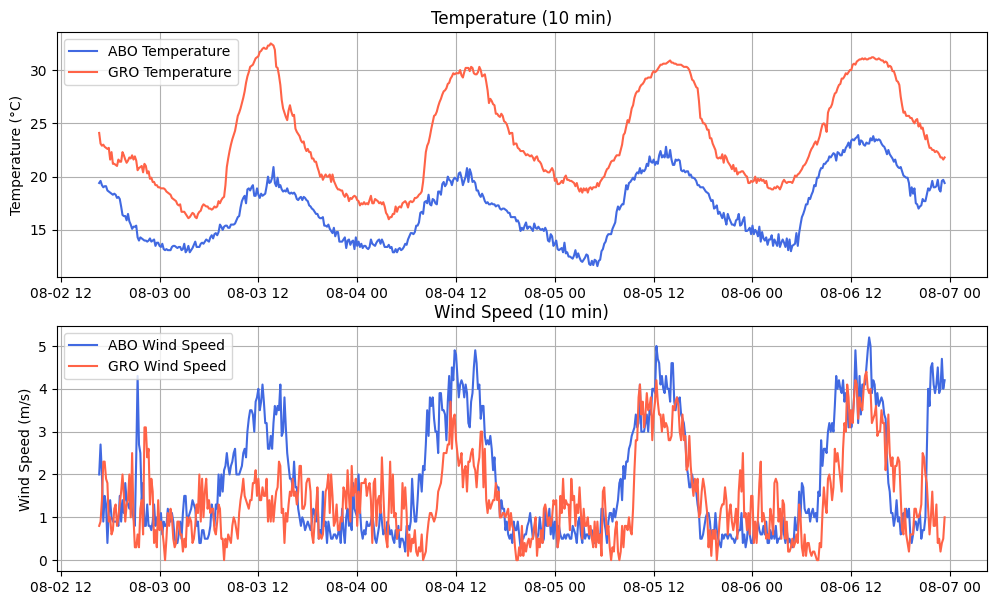

In [5]:
fig, ax = plt.subplots(2, figsize=(12,7))

# Plot temperature
ax[0].plot(df.index, df['ABO', 'temperature'], label='ABO Temperature', color='royalblue')
ax[0].plot(df.index, df['GRO', 'temperature'], label='GRO Temperature', color='tomato')
ax[0].set_title('Temperature (10 min)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

# Plot wind speed
ax[1].plot(df.index, df['ABO', 'wind_speed'], label='ABO Wind Speed', color='royalblue')
ax[1].plot(df.index, df['GRO', 'wind_speed'], label='GRO Wind Speed', color='tomato')
ax[1].set_title('Wind Speed (10 min)')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[1].legend()
ax[1].grid(True)

plt.show()

## Time series windowing

The `get_windows` function extracts sliding windows from the time series using a look-back window `w` and forecast horizon `h`
This prepares the data in a format that's easy to use with framework-specific datasets and data loaders (e.g., PyTorch, TensorFlow, JAX).

This returns arrays of shape `[n_w, w, n_s, n_f]` for the inputs `x` and `[n_w, h, n_s, n_f]` for the outputs `y`, where `n_w` is the number of windows (or examples/samples), `n_s` is the number of stations and `n_f` is the number of features.

In [6]:
lookback_size = 24
horizon_size = 6

windows = dataset.get_windows(
    window_size=24,  # number of lookback time steps
    horizon_size=6,  # number of lead times to be predicted
    parameters=['temperature', 'wind_speed', 'humidity'],
    stations=['ABO', 'KLO', 'GRO', 'LUG']
)

print(f"Windows x shape: \t{windows.x.shape}")
print(f"Windows mask_x shape: \t{windows.mask_x.shape}")
print(f"Windows y shape: \t{windows.y.shape}")
print(f"Windows mask_y shape: \t{windows.mask_y.shape}")

Windows x shape: 	(433699, 24, 4, 3)
Windows mask_x shape: 	(433699, 24, 4, 3)
Windows y shape: 	(433699, 6, 4, 3)
Windows mask_y shape: 	(433699, 6, 4, 3)


## Temporal re-sampling

We can initialize the dataset to resample the time series to a coarser frequency, such as from the default **10-minute** interval to **hourly**.
This is useful for reducing the variability of highly dynamic variables like wind speed, aligning with lower temporal resolutions, or shortening sequence length for training.

Each variable has a default aggregation method used during temporal resampling, which can be overridden using the `aggregation_method` parameter.

In [7]:
dataset = PeakWeatherDataset(
    freq='h', 
    aggregation_methods={'temperature': 'mean',
                         'humidity': 'mean'}
)

Just like before, let's look that temperature and wind speed for the stations of *Adelboden* and *Grono*, this time with an hourly temporal resolution.

In [8]:
df, mask = dataset.get_observations(
    stations=['ABO', 'GRO'], 
    parameters=['temperature', 'wind_speed'],
    first_date='2024-08-02 16:32',
    last_date='2024-08-06 23:26',
    return_mask=True
)

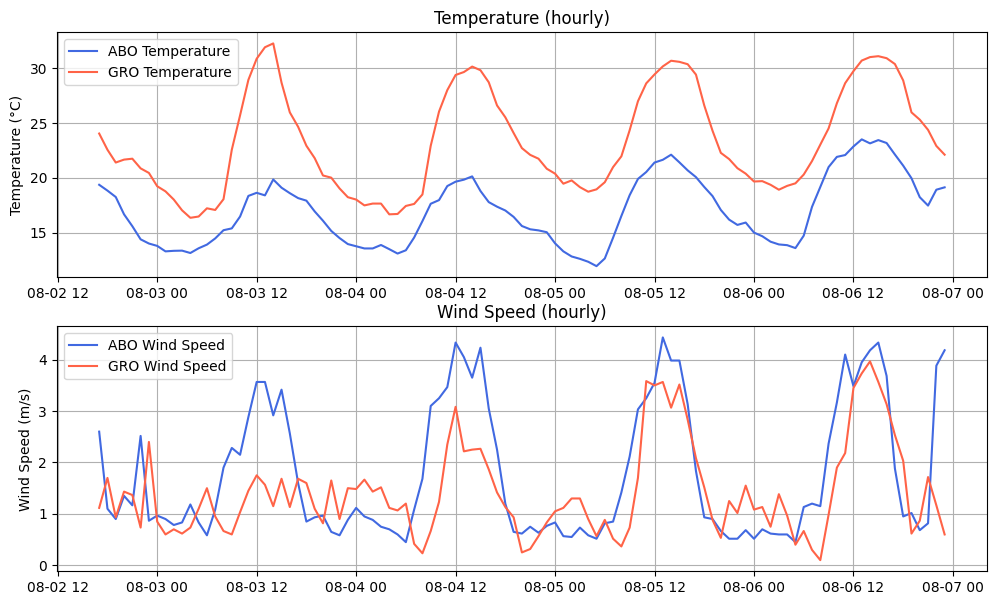

In [9]:
fig, ax = plt.subplots(2, figsize=(12,7))

# Plot temperature
ax[0].plot(df.index, df['ABO', 'temperature'], label='ABO Temperature', color='royalblue')
ax[0].plot(df.index, df['GRO', 'temperature'], label='GRO Temperature', color='tomato')
ax[0].set_title('Temperature (hourly)')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend()
ax[0].grid(True)

# Plot wind speed
ax[1].plot(df.index, df['ABO', 'wind_speed'], label='ABO Wind Speed', color='royalblue')
ax[1].plot(df.index, df['GRO', 'wind_speed'], label='GRO Wind Speed', color='tomato')
ax[1].set_title('Wind Speed (hourly)')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[1].legend()
ax[1].grid(True)

plt.show()

## ICON data

The dataset is complemented by the operational forecasts of the numerical weather prediction model **ICON-CH1-EPS** starting from May 2024. The data is available for all variables with the prediction interpolated to the closest grid cell to each station. 

It comes in the form of an `Xarray` dataset with dimensions `[lead,nat_abbr,realization,reftime]` where each realization is one of the 11 ensemble members produced by the model.

To obtain this data, the PeakWeather library needs to be installed with the extra dependency "topography". This will install `Xarray` and `Zarr`. 

In [5]:
ds = PeakWeatherDataset(extended_nwp_vars='all',
                        extended_topo_vars='all',
                        freq='h')

In [6]:
ds.available_icon

{'ew_wind',
 'humidity',
 'nw_wind',
 'precipitation',
 'pressure',
 'sunshine',
 'temperature',
 'wind_gust'}

In [ ]:
icon_data = ds.get_icon_data('temperature')

In [44]:
icon_data

<xarray.Dataset> Size: 1GB
Dimensions:      (lead: 34, nat_abbr: 302, realization: 11, reftime: 2557)
Coordinates:
  * lead         (lead) timedelta64[ns] 272B 00:00:00 ... 1 days 09:00:00
  * nat_abbr     (nat_abbr) <U5 6kB 'ABE' 'ABO' 'AEG' ... 'ZEV' 'ZWE' 'ZWK'
  * realization  (realization) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * reftime      (reftime) datetime64[ns] 20kB 2024-05-15T12:00:00 ... 2025-0...
Data variables:
    temperature  (reftime, lead, nat_abbr, realization) float32 1GB ...
Attributes:
    LICENSE:    CC-BY-4.0
    parameter:  Air temperature
    period:     2024-05:2025-03
    source:     MeteoSwiss (ICON-CH1-EPS)
    time_zone:  UTC

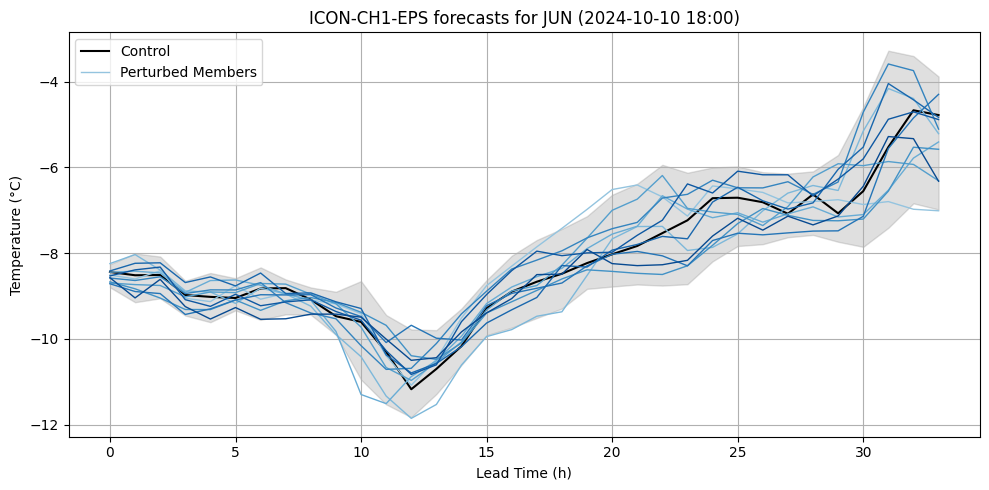

In [46]:
from matplotlib import cm
import numpy as np

reftime = '2024-10-10 18:00'
station_name = 'JUN'
ensembles = icon_data.sel(nat_abbr=station_name, reftime=reftime).to_array().data[0]


lead_times = np.arange(ensembles.shape[0]) 

n_ensembles = ensembles.shape[1]
colors = cm.Blues(np.linspace(0.4, 0.9, n_ensembles -1 ))  

fig, ax = plt.subplots(figsize=(10, 5))

for i in range(n_ensembles):
    if i == 0:
        ax.plot(ensembles[:, i], color='black', linewidth=1.5, label='Control')
    else:
        label = 'Perturbed Members' if i == 1 else None
        ax.plot(ensembles[:, i], color=colors[i - 1], linewidth=1, label=label)

mean = np.mean(ensembles, axis=1)
std = np.std(ensembles, axis=1)
ax.fill_between(lead_times, mean - 2*std, mean + 2*std, color='grey', alpha=0.25)

ax.set_title(f"ICON-CH1-EPS forecasts for {station_name} ({reftime})")
ax.set_xlabel("Lead Time (h)")
ax.set_ylabel("Temperature (°C)")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()